# Ridge Regression

Environment: R 3.6.1 and Jupyter notebook

Libraries used:
* dplyr
* ggplot2
* reshape2

## Introduction

In this notebook, there are 3 steps. 
* First step, the algorithm of stochastic gradient descent (SGD) and a L2 regularisation in linear regression will be explained.
* Second step, the algorithm in first step will be implemented.
* Third step, the algorithm on the dataset will be applied, and visualized when the lambda value of regularizer changes.

## Import libraries

In [1]:
options(warn=-1)
library(dplyr)
library(ggplot2)
library(reshape2)

set.seed(5201)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


## SGD Algorithm

The error function applied is `mean((predict_func(Phi, w) - label)^2) + .5 * lambda * w %*% w`. 

Also, because of the SGD, the data for training is only one. Therefore the error function for SGD can be considered as
\begin{equation}
\begin{aligned}
E &= \frac{1}{2}(y - \hat{y})^2 \\ &= \frac{1}{2}(y - w \cdot \phi(x))^2
\end{aligned}
\end{equation}

With the L2 regularizer the new error function should add the part of L2, which is
$$
\frac{\lambda}{2} \sum^{M-1}_{i=0}w^2_i
$$
where $N$ is the number of predictors, and the $\sum^{M-1}_{i=0}w^2_i$ is the sum of square of each weight, and the $\lambda$ is a hyperparameter which need to be specified manually.

For simple calculation, the <b>vectorization</b> is applied here. The $w^2$ is two $w$ vector dot product, which also can be considered as the sum of square of each element of vector $w$. Therefore, the new error function is,
$$
E = \frac{1}{2}(y - w \cdot \phi(x))^2 + \frac{\lambda}{2} w^2
$$

Then, take the derivative of $E$ of $w$.

\begin{equation}
\begin{aligned}
\nabla{E(w)} = \frac{dL}{dw} &= \frac{1}{2} \cdot 2(y - w\cdot\phi(x)) \cdot (-\phi(x)) + \lambda w \\ &= -(w\cdot\phi(x) - y) \cdot \phi(x) + \lambda w
\end{aligned}
\end{equation}

Actually, the $(w\cdot\phi(x) - y)$ is just the residual, with annotation $r$. Therefore, the gradient of $E(w)$ is,
$$
\nabla{E(w)} = -r\cdot\phi(x) + \lambda w
$$

Then, apply the gradient decent update, with the learning rate $\eta$,
$$
w \leftarrow w - \eta \nabla{E(w)}
$$

And then, re-calculate the gradient and update the weights until the number of iterations specified.

In [2]:
# reading the data
read_data <- function(fname, sc) {
  data <- read.csv(file = fname, head = TRUE, sep = ",")
  nr = dim(data)[1]
  nc = dim(data)[2]
  x = data[1:nr, 1:(nc - 1)]
  y = data[1:nr, nc]
  if (isTRUE(sc)) {
    x = scale(x)
    y = scale(y)
  }
  return(list("x" = x, "y" = y))
}

# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w) {  
  return(Phi %*% w)
}

# auxiliary function to calculate the objective function for the training
train_obj_func <- function(Phi, w, label, lambda) {
  # the L2 regulariser is already included in the objective function for training
  return(mean((predict_func(Phi, w) - label)^2) + .5 * lambda * w %*% w)
}

# auxiliary function to compute the error of the model
get_errors <- function(train_data, test_data, W) {
  n_weights = dim(W)[1]
  errors = matrix(, nrow = n_weights, ncol = 2)
  for (tau in 1:n_weights) {
    errors[tau, 1] = train_obj_func(train_data$x, W[tau,], train_data$y, 0)
    errors[tau, 2] = train_obj_func(test_data$x, W[tau,], test_data$y, 0)
  }
  return(errors)
}

##--- Stochastic Gradient Descent --------------------------------------------
sgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {

  train_len = dim(train_x)[1]
  tau_max = max_epoch * train_len

  W <- matrix(, nrow = tau_max, ncol = ncol(train_x))
  W[1,] <- runif(ncol(train_x))

  tau = 1 # counter
  obj_func_val <- matrix(, nrow = tau_max, ncol = 1)
  obj_func_val[tau, 1] = train_obj_func(train_x, W[tau,], train_y, lambda)

  while (tau <= tau_max) {

    # check termination criteria
    if (obj_func_val[tau, 1] <= epsilon) { break }

    # shuffle data:
    train_index <- sample(1:train_len, train_len, replace = FALSE)

    # loop over each datapoint
    for (i in train_index) {
      # increment the counter
      tau <- tau + 1
      if (tau > tau_max) { break }

      # make the weight update
      y_pred <- predict_func(train_x[i,], W[tau - 1,])
      W[tau,] <- sgd_update_weight(W[tau - 1,], train_x[i,], train_y[i], y_pred, lambda, eta)

      # keep track of the objective funtion
      obj_func_val[tau, 1] = train_obj_func(train_x, W[tau,], train_y, lambda) 
    }
  }
  # resulting values for the training objective function as well as the weights
  return(list('vals' = obj_func_val, 'W' = W))
}

## Read data

In [3]:
train_data <- read_data("train3.csv", TRUE)
x_train <- train_data$x
y_train <- train_data$y

test_data <- read_data("test3.csv", TRUE)
x_test <- test_data$x
y_test <- test_data$y

## Implement the SGD Algorithm in Linear Regression.

In [4]:
# updating the weight vector
sgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
  residual <- y_true - y_pred
  grad = -residual %*% x + lambda * W_prev
  return(W_prev - eta * grad)
}

## Visualization

The terminate criteria is $20 \times N$, where $N$ is the row of training data. 
Because of the SGD, each epoch is equivalent to $N$ iterations. Therefore, set the `max_epoch` as 20.

In [5]:
max_epoch <- 20
lambdas <- seq(0, 10, 0.4)
epsilon <- 0  # error tolerance for termination
eta <- 0.01  # learning rate

cal_errors_from_lambda <- function(lambda) {
  train_res <- sgd_train(x_train, y_train, lambda, eta, epsilon, max_epoch)
  last_weight <- train_res$W[nrow(train_res$W),] %>% as.matrix %>% t
  errors <- get_errors(train_data, test_data, last_weight) 
  # errors contains the train error and test error  
  errors  
}

errors <- lapply(lambdas, cal_errors_from_lambda) %>% 
            Reduce(f = rbind) %>% 
            cbind(lambdas, .) %>% 
            `colnames<-`(c("lambda", "train", "test")) %>% as.data.frame
errors %>% head

lambda,train,test
0.0,0.07926869,0.7232431
0.4,0.11548368,0.6491072
0.8,0.13453067,0.6248666
1.2,0.19805378,0.5943143
1.6,0.15794805,0.6086304
2.0,0.18686116,0.5946970


In [6]:
errors_melt <- errors %>% melt(id.vars = c("lambda")) %>% mutate(x = log(lambda))

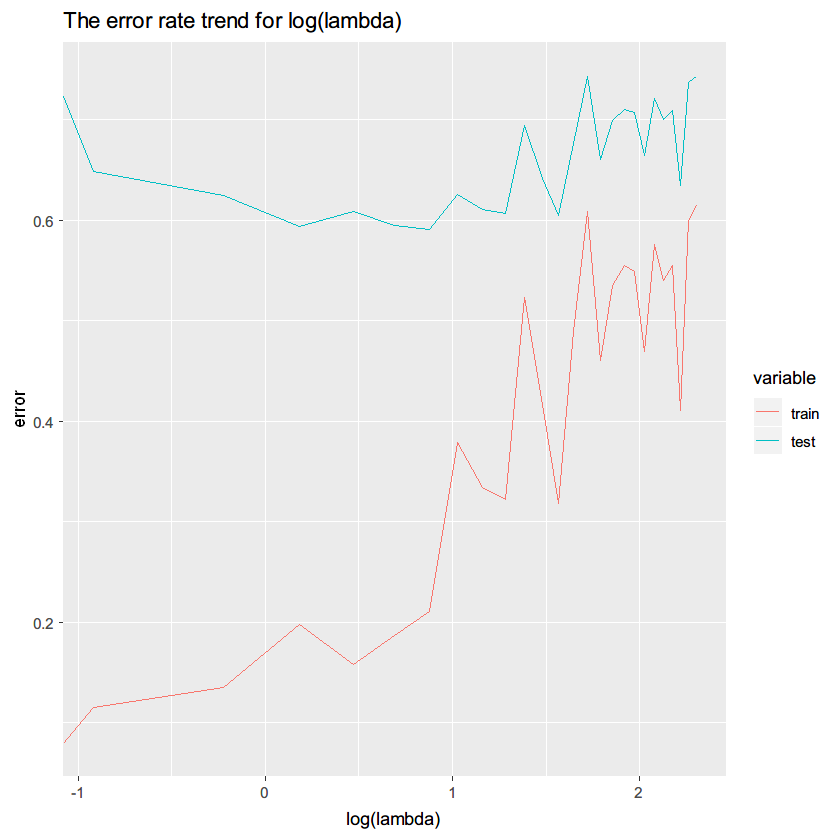

In [7]:
ggplot(data=errors_melt) + 
  geom_line(aes(x=x, y=value, color=variable)) +
  xlab("log(lambda)") +
  ylab("error") + 
  ggtitle("The error rate trend for log(lambda)")

In [8]:
lambdas[which.min(errors$test)]

[1] 2.4

Explain:

From the plot and the output of the lambda value for minimum test error, the best value of lambda for the model is 2.4 .

When the lambda value is high, the train error and test error increase, and the difference of train error and test error decreases. Therefore, the weights are more restrictive and the model is underfitting. The comlexity of model is decreased.

When the lambda value is low, the train error decreases and the test error increases, and the difference between train error and test error increases which means the model is overfitting. The comlexity of the model is increased.